In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import yaml
from IPython.display import Markdown, display
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats import linregress

In [2]:
# load yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
    DATA_PATH = config.get("data_path")
    if DATA_PATH is None:
        print("ERROR: No data path provided")
    USE_DRIVE = bool(config.get("use_drive", False))

In [4]:
# load from drive if requested
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


# Load data and prepare data

## Load

In [25]:
team_stat_df = pd.read_csv(os.path.join(DATA_PATH, "team_statistics_important_features.csv"))
team_stat_df["gameDate"] = pd.to_datetime(team_stat_df["gameDate"])
team_stat_df.set_index("gameDate", inplace=True)
team_stat_df.sort_index(inplace=True, ascending=True)

## Make uniform index


In [26]:
# uniform index df
team_stat_ui_df = team_stat_df.copy()
#team_stat_ui_df.sort_values("gameDate", inplace=True, ascending=True)

# reset the index to a uniform integer index
team_stat_ui_df.reset_index(drop=True, inplace=True)

# new column for the uniform integer index (optional, for clarity)
team_stat_ui_df["gameDate"] = team_stat_df.index

In [27]:
team_stat_ui_df.head()

,gameId,teamCity,teamName,opponentTeamCity,opponentTeamName,home,win,teamScore,opponentScore,threePointersPercentage,...,stealsPerPossession,threePointersAttemptedPerPossession,freeThrowsAttemptedPerPossession,reboundsDefensivePerPossession,reboundsOffensivePerPossession,foulsPersonalPerPossession,turnoversPerPossession,effectiveFieldGoalPercentage,trueShootingPercentage,gameDate
0,28100136,San Diego,Clippers,Chicago,Bulls,1,0,102,109,0.167,...,0.089534,0.059690,0.328293,0.248707,0.169121,0.308396,0.179069,40.035294,0.512460,1981-11-24 20:00:00
1,28100466,Seattle,SuperSonics,Philadelphia,76ers,0,0,87,100,0.000,...,0.039777,0.039777,0.238663,0.079554,0.129276,0.288385,0.188942,33.023810,0.460025,1982-01-23 20:00:00
2,28100466,Philadelphia,76ers,Seattle,SuperSonics,1,1,100,87,1.000,...,0.104364,0.009488,0.332068,0.199241,0.237192,0.275142,0.170778,39.005155,0.444840,1982-01-23 20:00:00
3,28100518,Milwaukee,Bucks,Dallas,Mavericks,1,1,117,92,0.333,...,0.090108,0.030036,0.270324,0.300360,0.160192,0.340408,0.170204,48.017241,0.591626,1982-02-05 20:00:00
4,28100518,Dallas,Mavericks,Milwaukee,Bucks,0,0,92,117,0.333,...,0.050201,0.030120,0.401606,0.190763,0.080321,0.271084,0.210843,32.021739,0.531178,1982-02-05 20:00:00


In [28]:
team_stat_ui_df.tail()

,gameId,teamCity,teamName,opponentTeamCity,opponentTeamName,home,win,teamScore,opponentScore,threePointersPercentage,...,stealsPerPossession,threePointersAttemptedPerPossession,freeThrowsAttemptedPerPossession,reboundsDefensivePerPossession,reboundsOffensivePerPossession,foulsPersonalPerPossession,turnoversPerPossession,effectiveFieldGoalPercentage,trueShootingPercentage,gameDate
90621,22401054,Brooklyn,Nets,Toronto,Raptors,1,0,86,116,0.195,...,0.057493,0.392871,0.182062,0.316213,0.095822,0.201227,0.182062,31.235632,0.450923,2025-03-26 19:30:00
90622,22401057,Denver,Nuggets,Milwaukee,Bucks,1,1,127,117,0.432,...,0.059595,0.367501,0.218514,0.377433,0.079460,0.119190,0.089392,49.205556,0.637039,2025-03-26 21:00:00
90623,22401057,Milwaukee,Bucks,Denver,Nuggets,0,0,117,127,0.432,...,0.040933,0.378633,0.133033,0.317233,0.081867,0.143266,0.112567,46.207865,0.617610,2025-03-26 21:00:00
90624,22401058,Phoenix,Suns,Boston,Celtics,1,0,102,132,0.317,...,0.071254,0.417345,0.213762,0.274837,0.111971,0.183225,0.132329,36.235632,0.529925,2025-03-26 22:00:00
90625,22401058,Boston,Celtics,Phoenix,Suns,0,1,132,102,0.423,...,0.081900,0.532351,0.225225,0.378788,0.112613,0.184275,0.102375,45.292135,0.668829,2025-03-26 22:00:00


## Functions

In [8]:
def plot_time_series_separated(overall_df, column, separation_dates: list[int, str] = None, fig_colsize=24, fig_rowsize=3, rolling_mean_window_size=30, yticks=None, scatter=True, scatter_size=1, sep_line_width=1):

    # plot whole ts
    fig, ax = plt.subplots(figsize=(fig_colsize, fig_rowsize))
    if scatter:
        ax.scatter(overall_df.index, overall_df[column], label=f'{column} (Overall)', s=scatter_size)
    else:
        ax.plot(overall_df.index, overall_df[column], label=f'{column} (Overall)')

    # plot separation lines
    if separation_dates is not None:
        for indexdate in separation_dates:
            index, date = indexdate
            ax.axvline(x=index, color='red', linestyle='-', linewidth=sep_line_width, label=f"rule change of {date}")
            # add under the line a text with the date, rotated 90 degrees, offset by a few pixels
            ax.text(index, overall_df[column].max(), date, ha='right', va='bottom', color='red', rotation=90)

    if rolling_mean_window_size is not None:
        # plot moving average
        rolling_mean = overall_df[column].rolling(window=rolling_mean_window_size).mean()
        ax.plot(overall_df.index, rolling_mean, label=f'Rolling Mean ({rolling_mean_window_size} days)', color='orange')
        ax.legend()

    # labels
    ax.set_title(f'{column} (Overall)')
    ax.set_xlabel('Game Date')
    ax.set_ylabel(column)
    ax.grid(True)
    if yticks is not None:
        ax.set_yticks(yticks)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))

    plt.show()

# ARIMA

## For `teamScore`

Close to what we have had in `./ts_team_analysis.py`. We do the other columns later.

In [9]:
def plot_acf_pacf(df, col: str, lags=40):
    # source: https://www.datacamp.com/tutorial/arima
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in the DataFrame.")

    # Drop NaN values from the specified column
    series = df[col].dropna()

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    # Plot ACF
    plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')

    # Plot PACF
    plot_pacf(series, lags=lags, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [45]:
# train test split
split_ratio = 0.8
train_size = int(len(team_stat_ui_df) * split_ratio)
train_ui, test_ui = team_stat_ui_df[:train_size], team_stat_ui_df[train_size:]

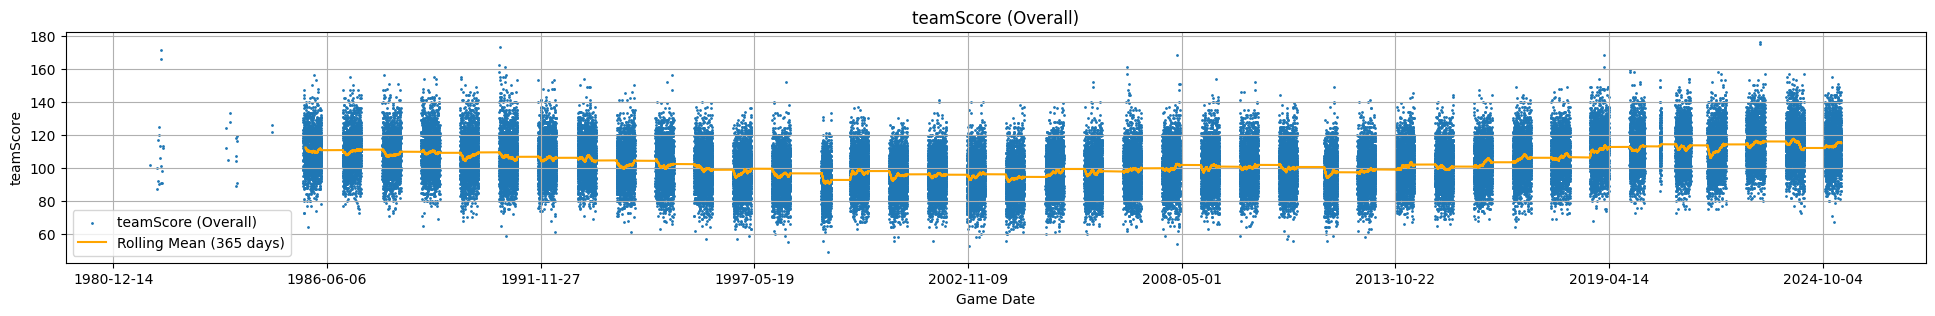

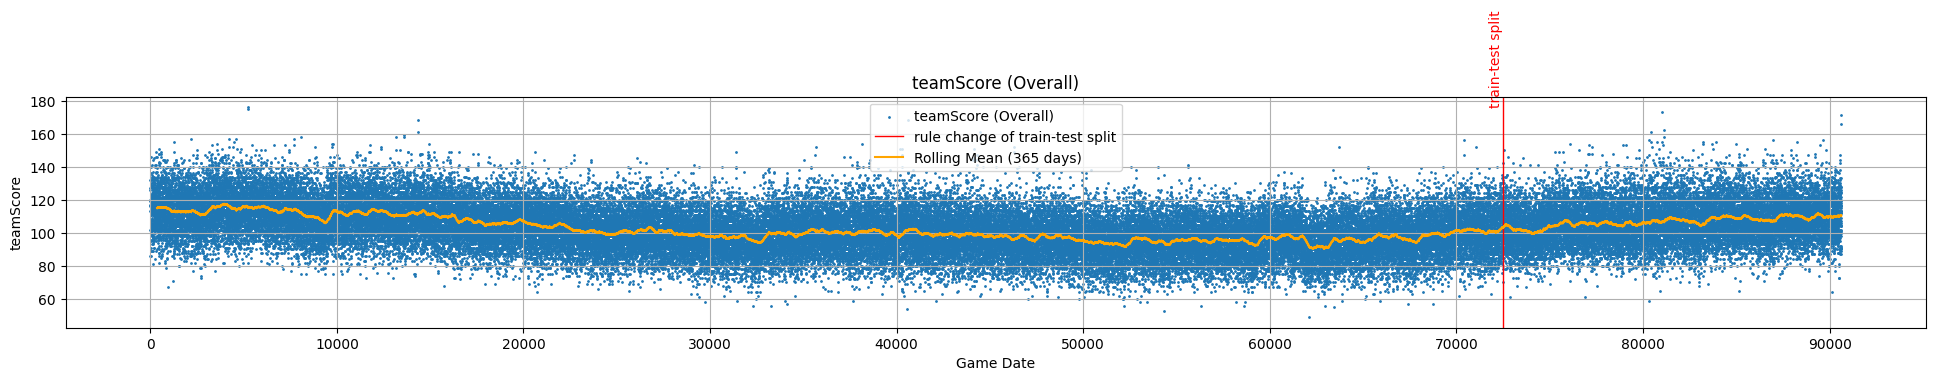

In [48]:
# plot teamScore again to know what we work with
plot_time_series_separated(team_stat_df, "teamScore", rolling_mean_window_size=365)  # for completeness with the original dates and seasonality
plot_time_series_separated(team_stat_ui_df, "teamScore", rolling_mean_window_size=365,   # with uniform index (what we will be using)
                           separation_dates=[(max(train_ui.index), "train-test split")])

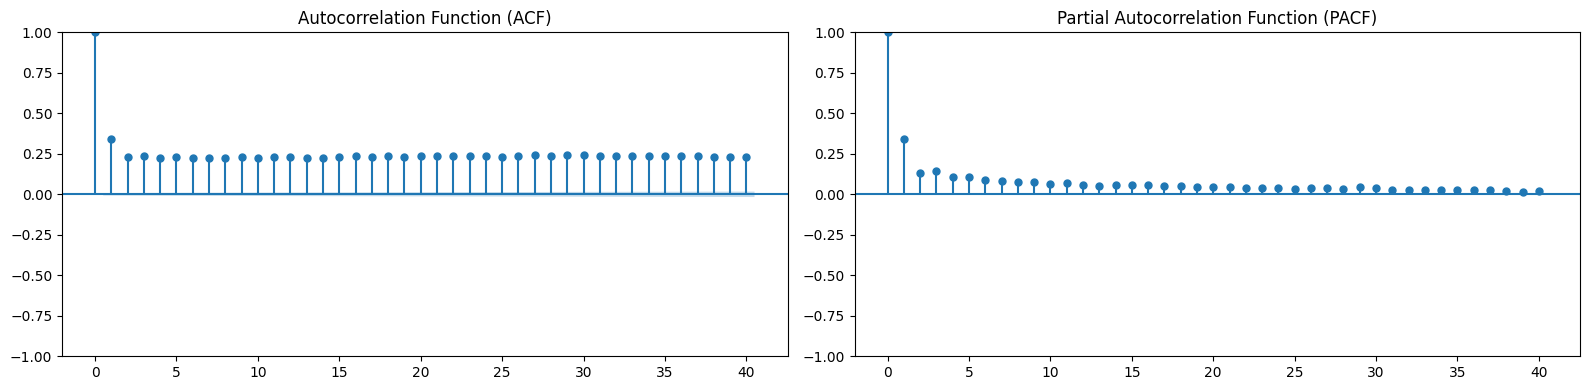

In [75]:
plot_acf_pacf(train_ui, "teamScore")

$q = 1$ and $p=3$

In [51]:
p = 3
d = 0
q = 1

In [52]:
sarima_model = SARIMAX(train_ui["teamScore"], order=(p, d, q))
sarima_model_fit = sarima_model.fit()

print(sarima_model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:              teamScore   No. Observations:                72500
Model:               SARIMAX(3, 0, 1)   Log Likelihood             -282720.154
Date:                Mon, 05 May 2025   AIC                         565450.307
Time:                        13:01:34   BIC                         565496.264
Sample:                             0   HQIC                        565464.459
                              - 72500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1421      0.000   3578.727      0.000       1.141       1.143
ar.L2         -0.1654      0.004    -44.524      0.000      -0.173      -0.158
ar.L3          0.0233      0.004      6.384      0.0

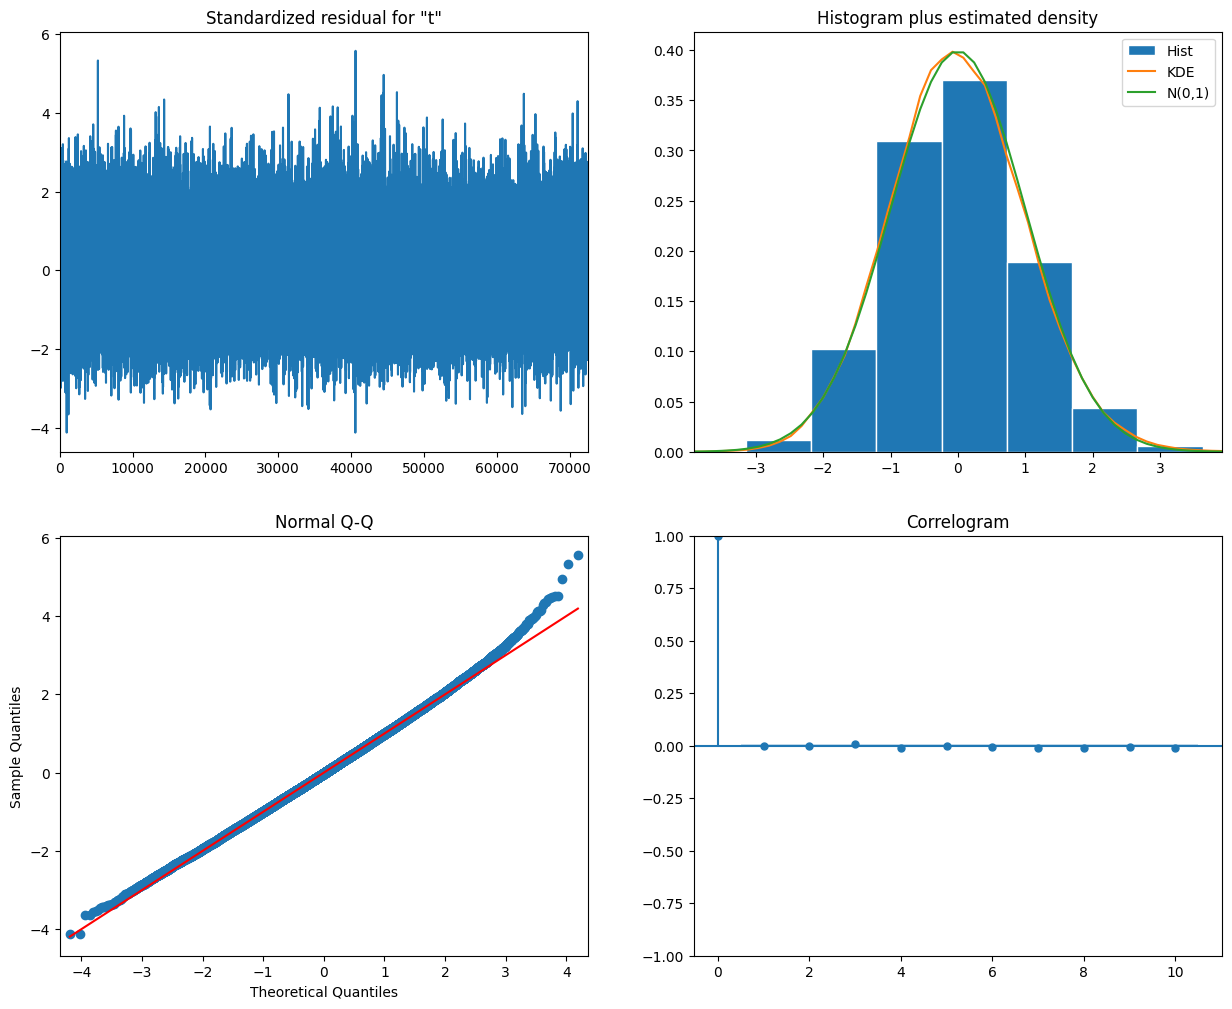

In [53]:
# plot residuals
sarima_model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

In [66]:
# Forecast
forecast = sarima_model_fit.forecast(steps=len(test_ui))

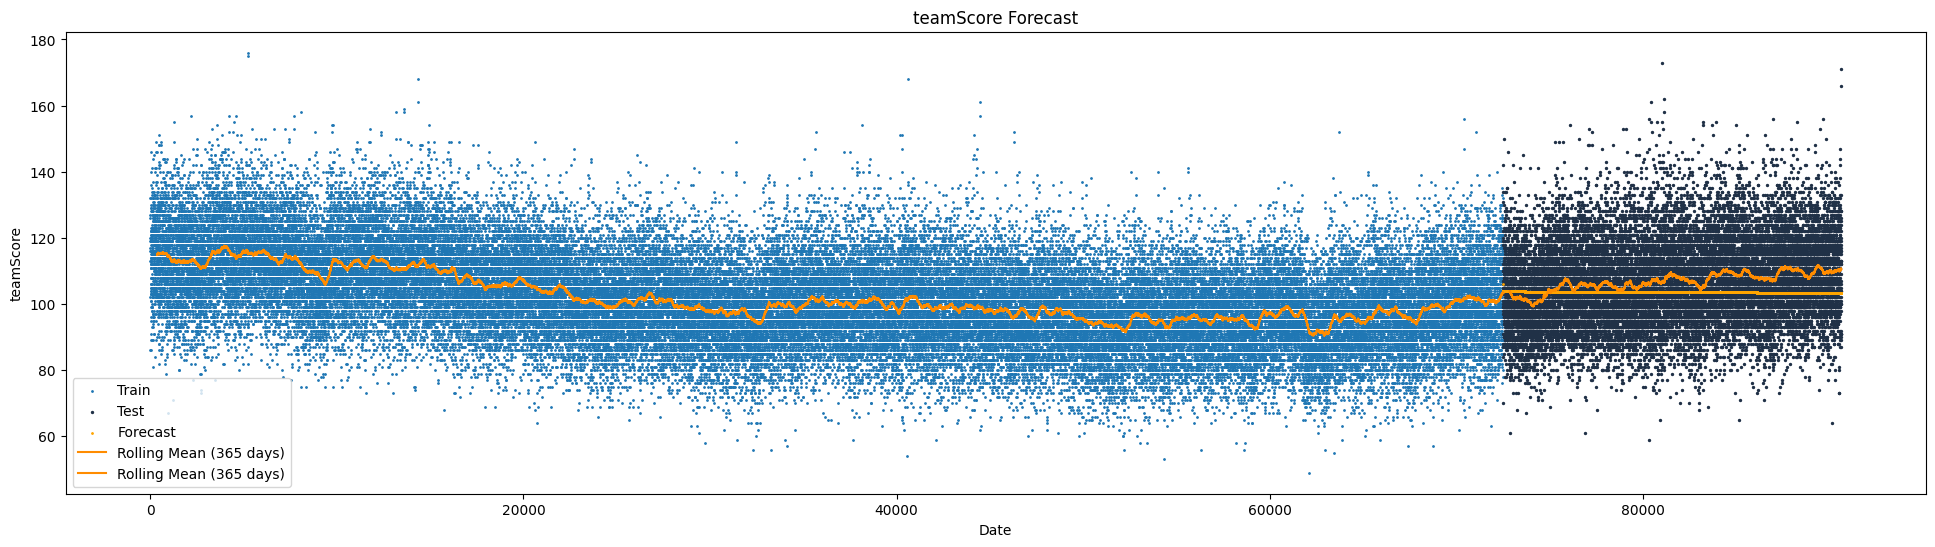

In [70]:
# Plot the results with specified colors
plt.figure(figsize=(24,6))
plt.scatter(train_ui.index, train_ui["teamScore"], label='Train', s=1)
plt.scatter(test_ui.index, test_ui["teamScore"], label='Test', color='#203147', s=2)
plt.scatter(test_ui.index, forecast, label='Forecast', color='orange', s=1)
# plot moving average
rolling_mean_train = train_ui["teamScore"].rolling(window=365).mean()
rolling_mean_test = test_ui["teamScore"].rolling(window=365).mean()
plt.plot(train_ui.index, rolling_mean_train, label=f'Rolling Mean (365 days)', color='darkorange')
plt.plot(test_ui.index, rolling_mean_test, label=f'Rolling Mean (365 days)', color='darkorange')
plt.title('teamScore Forecast')
plt.xlabel('Date')
plt.ylabel('teamScore')
plt.legend()
plt.show()


absolute rubbish

### seasonal decompse first






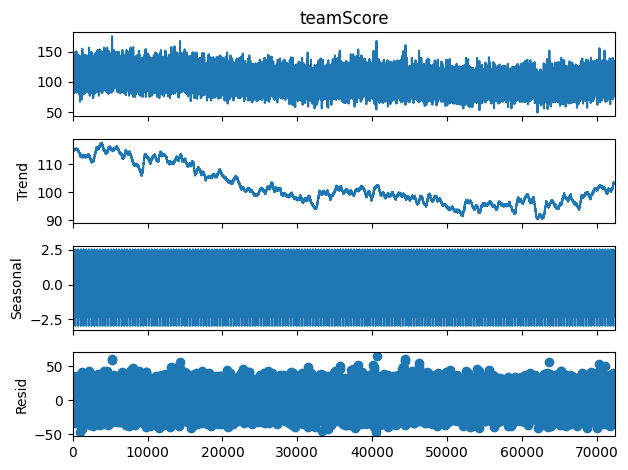

In [71]:
# remove variance through seasonal decompose
decomposed = seasonal_decompose(train_ui["teamScore"], model="additive", period=365)
decomposed.plot()
plt.show()

<ipython-input-118-9f3c09fc4dcd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ui["teamScore_rollingmean"] = train_ui["teamScore"] - decomposed.resid + decomposed.seasonal


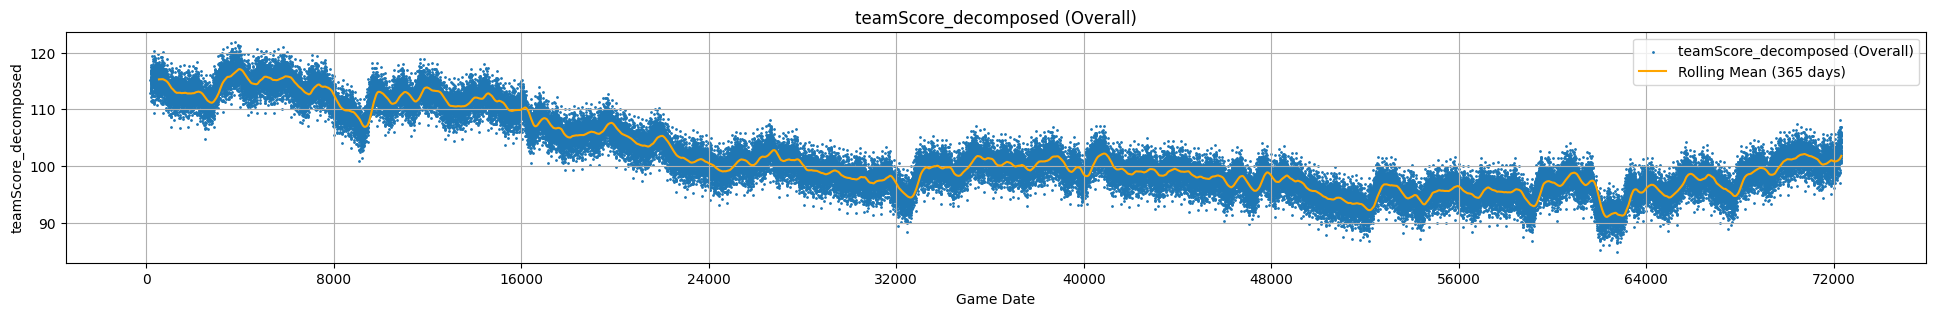

In [118]:
# remove variance and resid from train_ui df
train_ui["teamScore_rollingmean"] = train_ui["teamScore"] - decomposed.resid + decomposed.seasonal

# plot train_ui
plot_time_series_separated(train_ui, "teamScore_decomposed", rolling_mean_window_size=365)

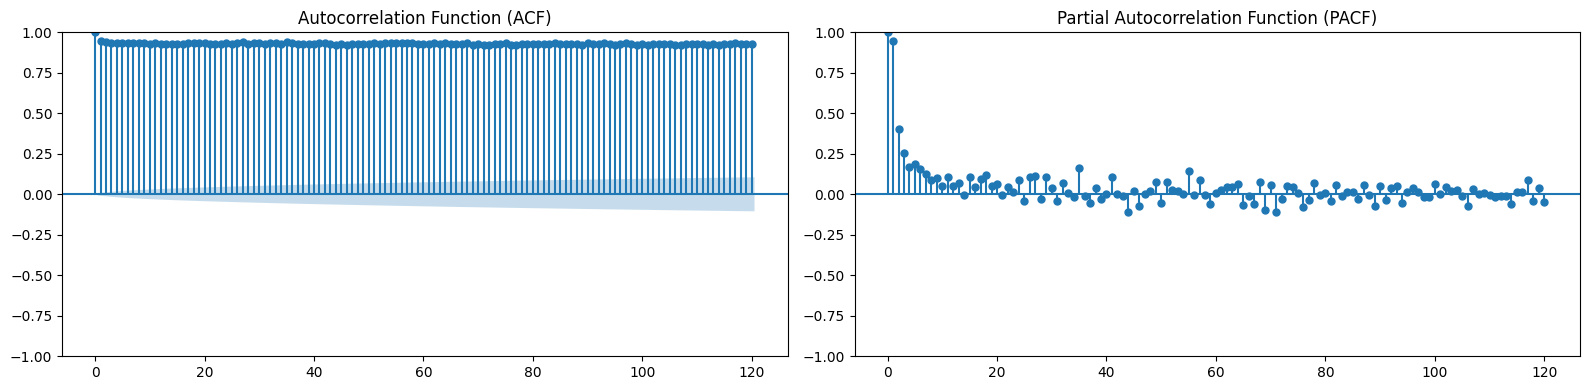

In [119]:
plot_acf_pacf(train_ui, "teamScore_decomposed", lags=120)

In [146]:
p = 3 # guessed something along those lines
d = 1 # because transposed once
q = 15  # high value

In [147]:
# arima
arima_model_decomposed = ARIMA(train_ui["teamScore_decomposed"], order=(p, d, q))
arima_model_decomposed_fit = arima_model_decomposed.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


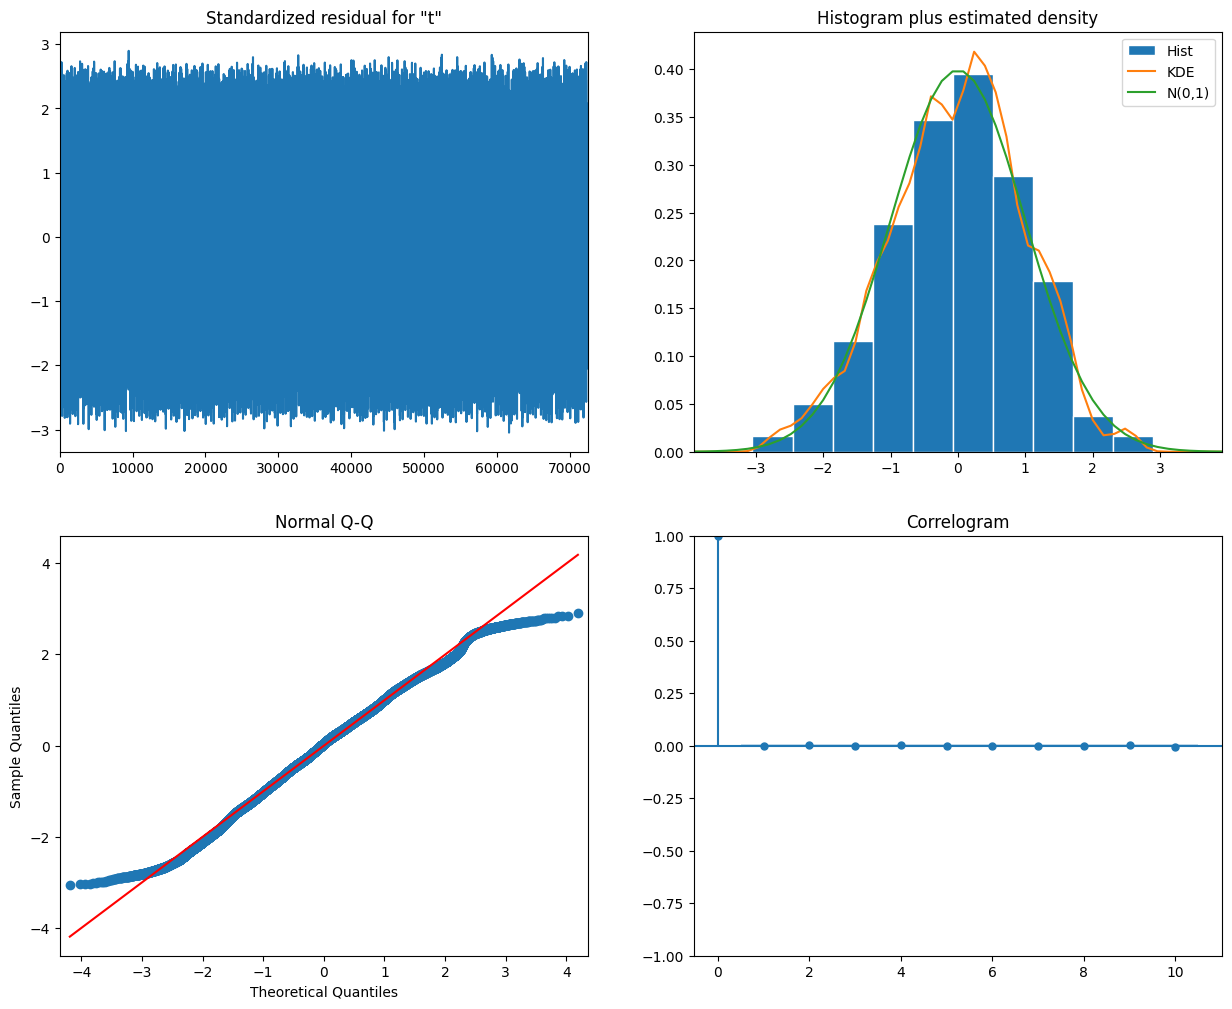

In [148]:
# plot residuals
arima_model_decomposed_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

not really normal

In [149]:
# Forecast
forecast_decomposed = arima_model_decomposed_fit.forecast(steps=len(test_ui))

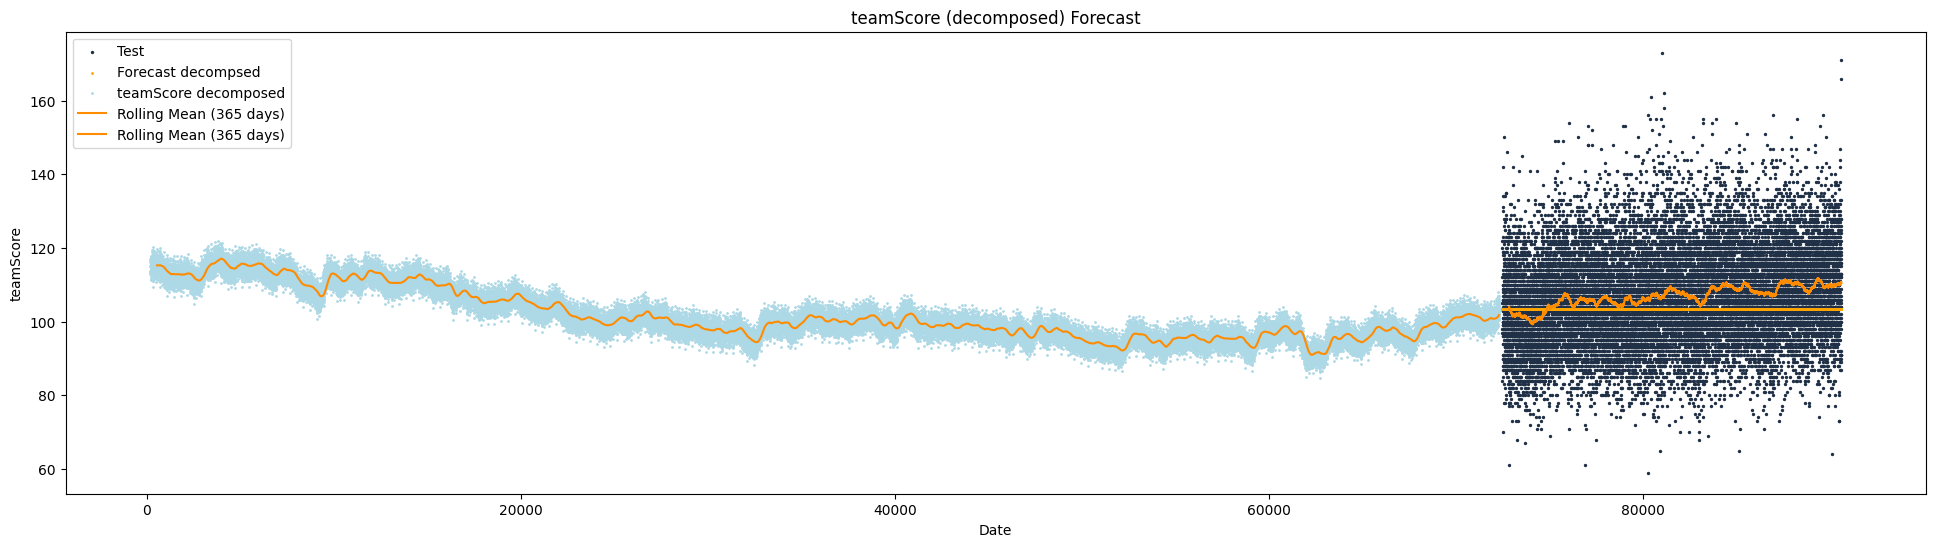

In [150]:
# Plot the results with specified colors
plt.figure(figsize=(24,6))
#plt.scatter(train_ui.index, train_ui["teamScore"], label='Train', s=1)
plt.scatter(test_ui.index, test_ui["teamScore"], label='Test', color='#203147', s=2)

plt.scatter(test_ui.index, forecast_decomposed, label='Forecast decompsed', s=1, color="orange")

plt.scatter(train_ui.index, train_ui["teamScore_decomposed"], label=f'teamScore decomposed', s=1, color="lightblue")

rolling_mean_train = train_ui["teamScore_decomposed"].rolling(window=365).mean()
plt.plot(train_ui.index, rolling_mean_train, label=f'Rolling Mean (365 days)', color='darkorange')


rolling_mean_test = test_ui["teamScore"].rolling(window=365).mean()
plt.plot(test_ui.index, rolling_mean_test, label=f'Rolling Mean (365 days)', color='darkorange')

plt.title('teamScore (decomposed) Forecast')
plt.xlabel('Date')
plt.ylabel('teamScore')
plt.legend()
plt.show()


does not look better

In [91]:
# rolling mean
team_stat_ui_df['teamScore_rollingmean'] = team_stat_ui_df['teamScore'].rolling(window=365).mean()

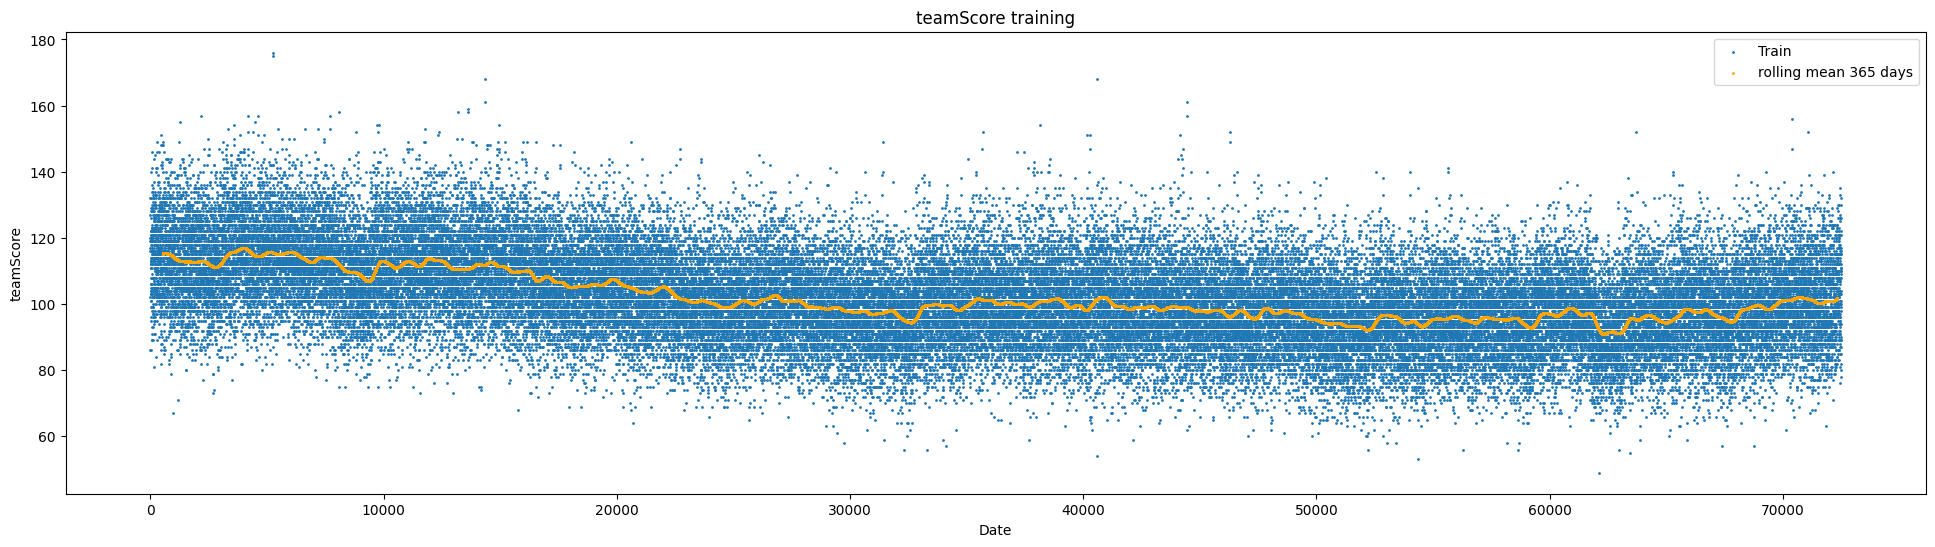

In [94]:
# Plot the results with specified colors
plt.figure(figsize=(24,6))
plt.scatter(train_ui.index, train_ui["teamScore"], label='Train', s=1)
plt.scatter(train_ui.index, train_ui["teamScore_rollingmean"], label='rolling mean 365 days', color='orange', s=1)
plt.title('teamScore training')
plt.xlabel('Date')
plt.ylabel('teamScore')
plt.legend()
plt.show()


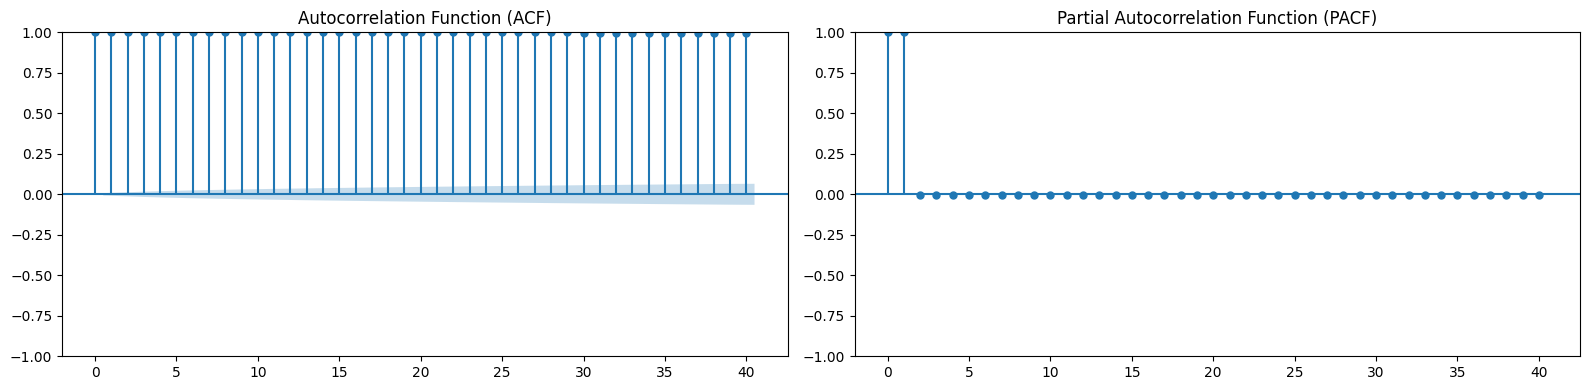

In [97]:
plot_acf_pacf(train_ui, col="teamScore_rollingmean")

In [113]:
p = 2
d = 0
q = 10

In [114]:
# arima
arima_model_rollingmean = ARIMA(train_ui["teamScore_rollingmean"], order=(p, d, q))
arima_model_rollingmean_fit = arima_model_rollingmean.fit()

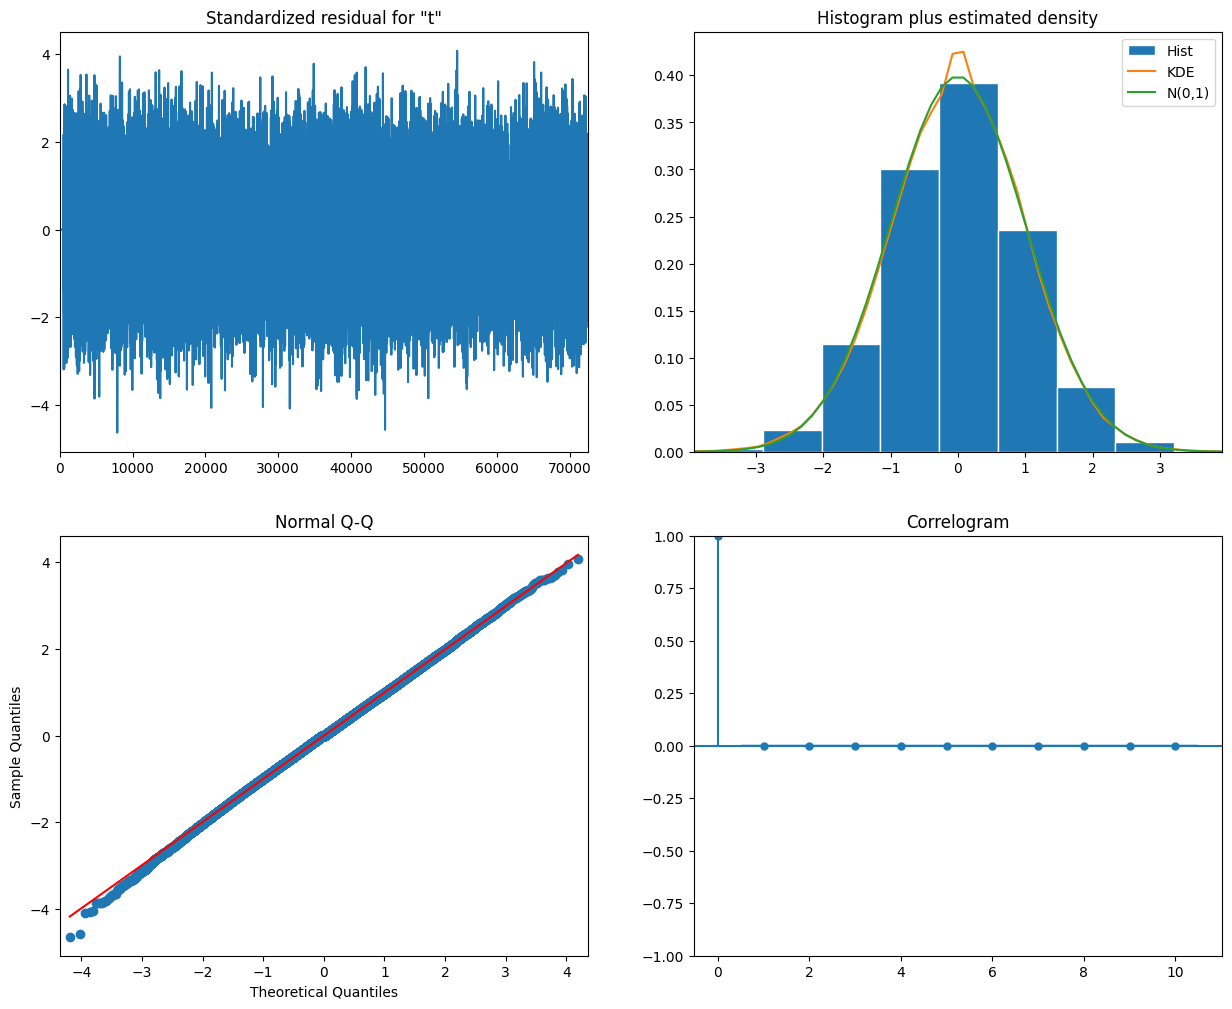

In [115]:
# plot residuals
arima_model_rollingmean_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

In [116]:
# Forecast
forecast = arima_model_rollingmean_fit.forecast(steps=len(test_ui))

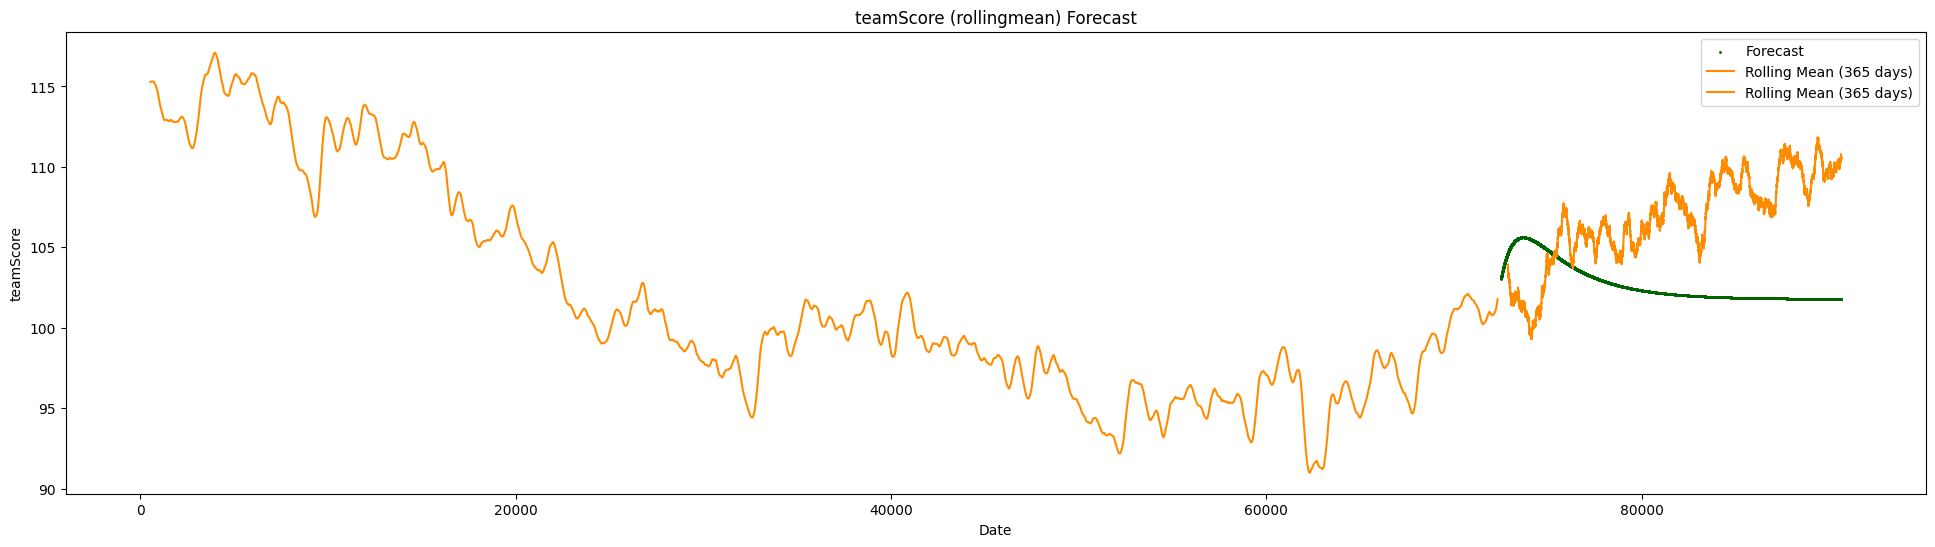

In [117]:
# Plot the results with specified colors
plt.figure(figsize=(24,6))
#plt.scatter(train_ui.index, train_ui["teamScore"], label='Train', s=1)
#plt.scatter(test_ui.index, test_ui["teamScore"], label='Test', color='#203147', s=2)

plt.scatter(test_ui.index, forecast, label='Forecast', color='darkgreen', s=1)

plt.plot(train_ui.index, train_ui["teamScore_rollingmean"], label=f'Rolling Mean (365 days)', color='darkorange')

rolling_mean_test = test_ui["teamScore"].rolling(window=365).mean()
plt.plot(test_ui.index, rolling_mean_test, label=f'Rolling Mean (365 days)', color='darkorange')

plt.title('teamScore (rollingmean) Forecast')
plt.xlabel('Date')
plt.ylabel('teamScore')
plt.legend()
plt.show()


# ARIMA only on the last few years

Idea from other machine learning frameworks, which use a limited timespan of the last few percents, not the whole timespan. This is especially important if the data is not really seasonal, but represents more the fluctuation of data over time. this is the case here as well. thus we want to try that.

In [29]:
# use only the last 5 years of the train_stat_ui dataframe
team_stat_ui_df_last5years = team_stat_ui_df[team_stat_ui_df["gameDate"] >= "2017-01-01"]
team_stat_ui_df_last5years.describe()

,gameId,home,win,teamScore,opponentScore,threePointersPercentage,freeThrowsPercentage,assistsPerPossession,blocksPerPossession,stealsPerPossession,threePointersAttemptedPerPossession,freeThrowsAttemptedPerPossession,reboundsDefensivePerPossession,reboundsOffensivePerPossession,foulsPersonalPerPossession,turnoversPerPossession,effectiveFieldGoalPercentage,trueShootingPercentage,gameDate
count,2.005900e+04,20059.000000,20059.000000,20059.000000,20059.000000,20059.000000,20059.000000,20059.000000,20059.000000,20059.000000,20059.000000,20059.000000,20059.000000,20059.000000,20059.000000,20059.000000,20059.000000,20059.000000,20059
mean,2.201671e+07,0.500922,0.503166,111.489556,111.350715,0.359729,0.775810,0.244968,0.047853,0.075118,0.329054,0.219868,0.332962,0.101296,0.194188,0.137036,41.229375,0.569970,2021-03-22 00:03:04.411984896
min,2.160027e+07,0.000000,0.000000,67.000000,67.000000,0.056000,0.143000,0.072917,0.000000,0.000000,0.094419,0.010369,0.156678,0.000000,0.044504,0.010762,21.320513,0.356350,2017-01-01 18:00:00
25%,2.180057e+07,0.000000,0.000000,103.000000,103.000000,0.302000,0.714000,0.209916,0.029892,0.055432,0.279156,0.172624,0.297503,0.074508,0.166863,0.110932,37.253290,0.527250,2019-01-04 20:30:00
50%,2.200081e+07,1.000000,1.000000,111.000000,111.000000,0.357000,0.783000,0.242915,0.046245,0.073008,0.326862,0.215961,0.332364,0.098425,0.193465,0.135360,41.181818,0.568370,2021-04-14 16:30:00
75%,2.220102e+07,1.000000,1.000000,120.000000,120.000000,0.417000,0.846000,0.277897,0.062241,0.093014,0.376796,0.264120,0.367221,0.124712,0.220264,0.161229,44.266856,0.611387,2023-03-13 19:15:00
max,2.240123e+07,1.000000,1.000000,176.000000,176.000000,0.842000,1.000000,0.464166,0.197889,0.209684,0.673884,0.608596,0.535402,0.281335,0.384334,0.305135,65.184685,0.808484,2025-03-26 22:00:00
std,2.497103e+05,0.500012,0.500002,12.719663,12.723730,0.085734,0.101585,0.050720,0.024359,0.028103,0.072270,0.067870,0.051342,0.037365,0.039790,0.036966,5.237250,0.061568,NaN


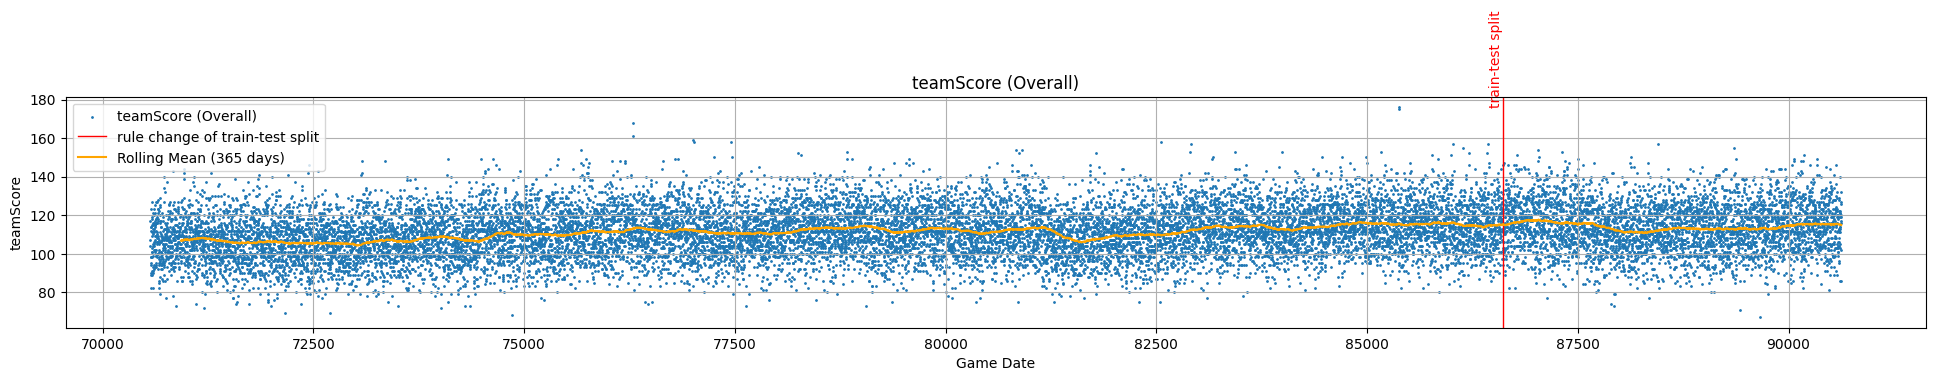

In [32]:
# train test split
split_ratio = 0.8
train_size = int(len(team_stat_ui_df_last5years) * split_ratio)
train_ui, test_ui = team_stat_ui_df_last5years[:train_size], team_stat_ui_df_last5years[train_size:]

# plot
plot_time_series_separated(team_stat_ui_df_last5years, "teamScore", rolling_mean_window_size=365,
                           separation_dates=[(max(train_ui.index), "train-test split")])


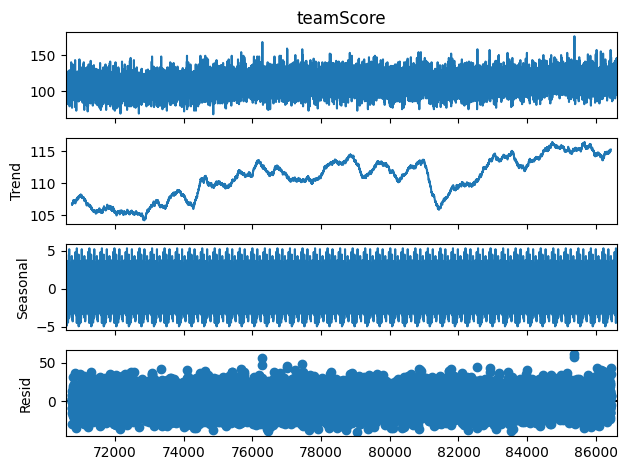

In [33]:
# seasonal decompose
decomposed_5y = seasonal_decompose(train_ui["teamScore"], model="additive", period=365)
decomposed_5y.plot()
plt.show()

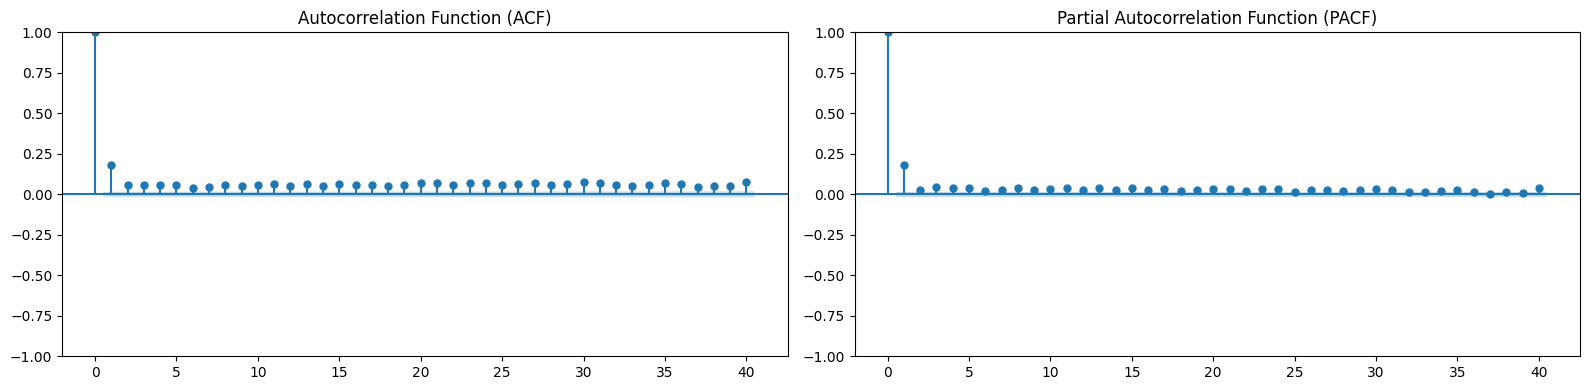

In [34]:
# plot acf pacf
plot_acf_pacf(train_ui, col="teamScore")

In [35]:
p = 3
d = 0
q = 3

In [39]:
# arima
arima_model_5y = ARIMA(train_ui["teamScore"], order=(p, d, q))
arima_model_5y_fit = arima_model_5y.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

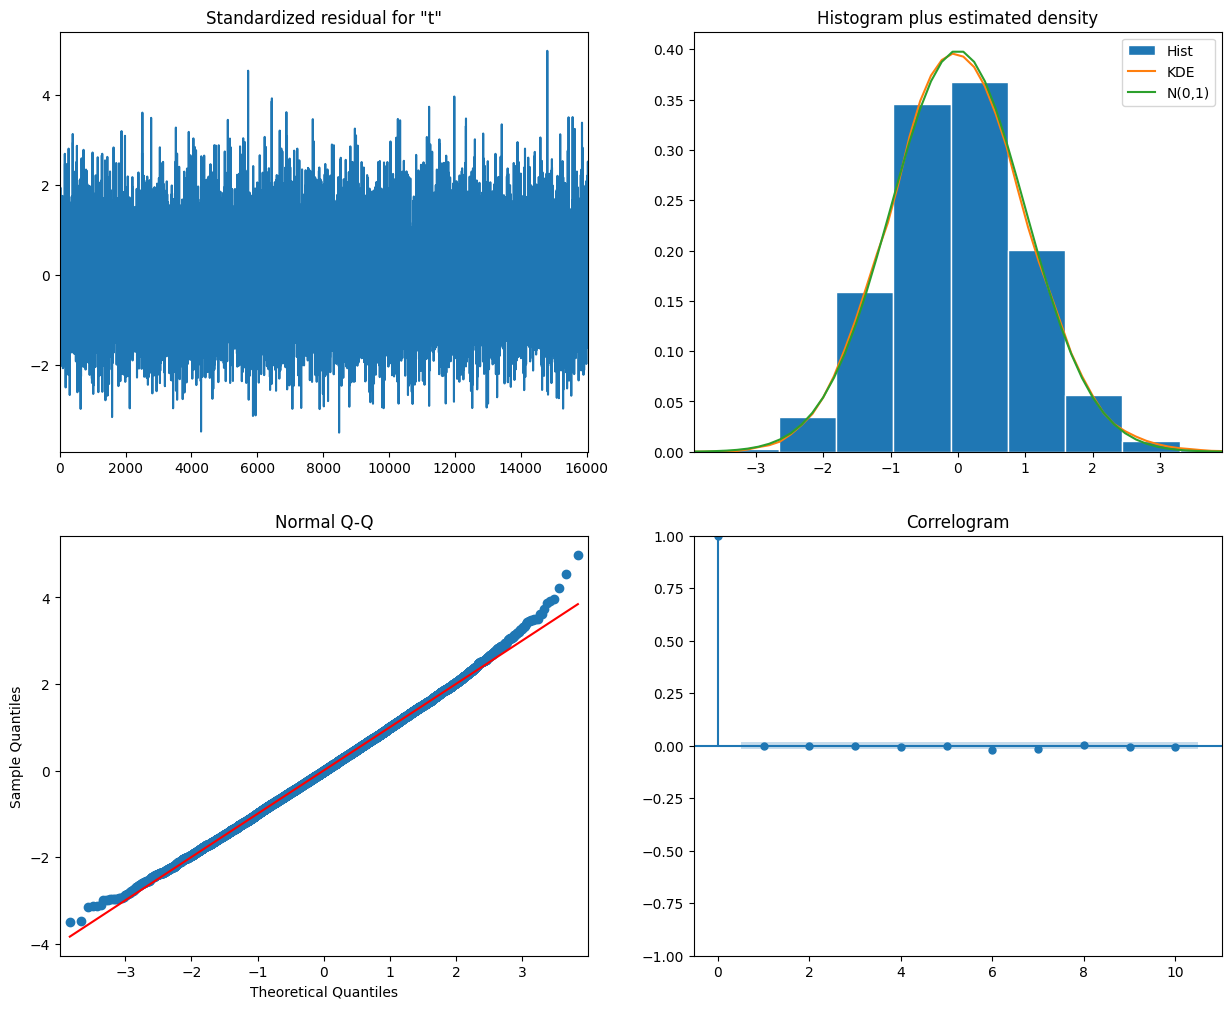

In [40]:
# plot residuals
arima_model_5y_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

In [41]:
# Forecast
forecast = arima_model_5y_fit.forecast(steps=len(test_ui))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


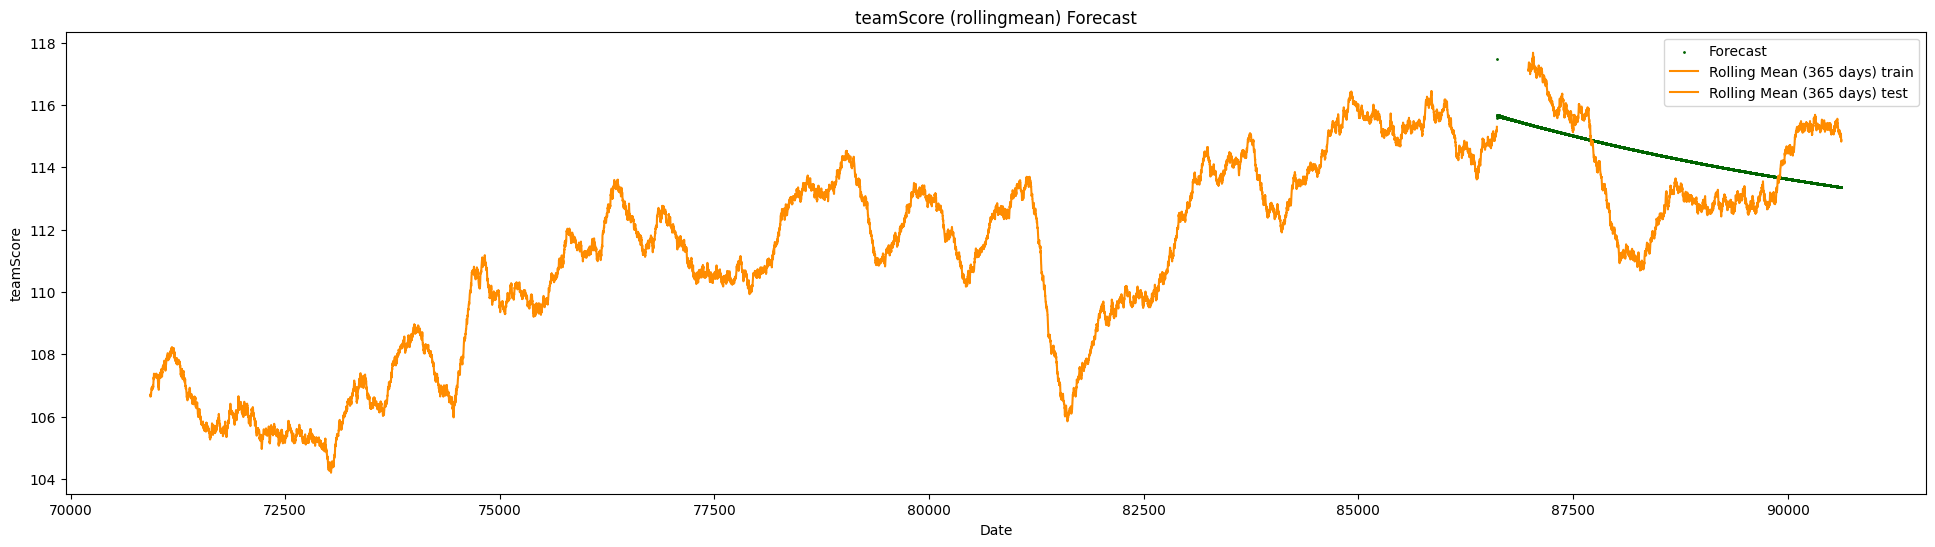

In [44]:
# Plot the results with specified colors
plt.figure(figsize=(24,6))
#plt.scatter(train_ui.index, train_ui["teamScore"], label='Train', s=1)
#plt.scatter(test_ui.index, test_ui["teamScore"], label='Test', color='#203147', s=2)

plt.scatter(test_ui.index, forecast, label='Forecast', color='darkgreen', s=1)

rolling_mean_train = train_ui["teamScore"].rolling(window=365).mean()
plt.plot(train_ui.index, rolling_mean_train, label=f'Rolling Mean (365 days) train', color='darkorange')
rolling_mean_test = test_ui["teamScore"].rolling(window=365).mean()
plt.plot(test_ui.index, rolling_mean_test, label=f'Rolling Mean (365 days) test', color='darkorange')

plt.title('teamScore (rollingmean) Forecast')
plt.xlabel('Date')
plt.ylabel('teamScore')
plt.legend()
plt.show()


works slightly better, at least detects downward trend...
